## Imports

In [37]:

# data processing
import numpy as np
import pandas as pd
from numpy import var
import warnings
import copy

# machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc
from mlxtend.feature_selection import SequentialFeatureSelector

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# inner functions
from svm_utils import *
from data_configuration import *

In [38]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# The problem

Analyzing model faults and mispredictions can be a daunting task due to the intricate nature of machine learning models and their training processes. Manually performing feature selection and scaling hyperparameters during ML training can make the challenge frustrated, and leading to a longer and more complex process.

# Our solution

## Machine learning methods

## K-Means functions

''k_means_identify'' function train a logistic regression model on training data and evaluate its performance using accuracy, precision, recall, and f1 score metrics.
Identify mispredictions by comparing the model's predictions with actual target variables, and group them into similar clusters using k-means clustering.
Select the most important features for each cluster of mispredictions using SelectKBest method.
Remove the least important features, retrain the model, and calculate the improvement in accuracy, precision, recall, and f1 score compared to the original model.

In [39]:
def k_means_identify(X_train, X_test, Y_train, Y_test, label):
    # Collect data on model faults and mispredictions : Logistic Regression
    # Scale the inputs to have zero mean and unit variance
    scaler = StandardScaler()
    reg_model = LogisticRegression(max_iter=1000)
    reg_model.fit(scaler.fit_transform(X_train), Y_train)

    # Predict the target variable for the testing set
    Y_pred = reg_model.predict(scaler.fit_transform(X_test))
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    print('Logistic Regression before changes: accuracy, precision, recall, f1: ', accuracy, precision, recall, f1)
    
    # Create a bar plot of the evaluation metrics
    metric = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    value = [accuracy, precision, recall, f1]
    plt.bar(metric, value)
    plt.xlabel('Evaluation Metrics before k-means')
    plt.ylabel('Value')
    plt.show()

    # Identify the mispredictions and their associated feature values
    data_test = X_test.copy()
    data_test[label] = Y_test
    data_test['Prediction'] = Y_pred
    mispredictions = data_test[data_test[label] != data_test['Prediction']]

    # Use the elbow method to determine the optimal number of clusters
    mispredictions_array = mispredictions.drop([label, 'Prediction'], axis=1).values
    distortions = []
    for n_clusters in range(2, 20):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
        kmeans.fit(mispredictions_array)
        distortions.append(kmeans.inertia_)

    # Select the optimal number of clusters based on the elbow method
    best_n_clusters = 0
    best_distortion = float('inf')
    for i in range(len(distortions) - 1):
        if abs(distortions[i] - distortions[i + 1]) < best_distortion:
            best_n_clusters = i + 2
            best_distortion = abs(distortions[i] - distortions[i + 1])

    # Use the optimal number of clusters determined by the elbow method
    n_clusters = best_n_clusters
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    Y_pred_dict = {}

    # Use k-means clustering to identify groups of similar customers
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(mispredictions.drop([label, 'Prediction'], axis=1))

    # Use SelectKBest to identify the important features
    for i in range(n_clusters):
        cluster_data = mispredictions[clusters == i].drop([label, 'Prediction'], axis=1)
        X = cluster_data.values
        Y = data_test[data_test[label] != data_test['Prediction']][label][clusters == i]

        # Remove constant features
        constant_features = [j for j, column in enumerate(X.T) if var(column) == 0]
        X = np.delete(X, constant_features, axis=1)
        cluster_data = cluster_data.drop(cluster_data.columns[constant_features], axis=1)
        if X.shape[1] == 0:
            print("All features are constant in this cluster")
        else:
            selector = SelectKBest(f_classif, k=1)
            selector = selector.fit(X, Y)
            mask = selector.get_support()
            important_features = cluster_data.columns[mask]

            # Make changes to the predictive model by removing the least important features
            X_train_new = X_train.drop(important_features, axis=1)
            X_test_new = X_test.drop(important_features, axis=1)
            model_new = LogisticRegression(max_iter=1000)
            model_new.fit(scaler.fit_transform(X_train_new), Y_train)
            Y_pred_new = model_new.predict(scaler.fit_transform(X_test_new))
            Y_pred_dict.update({i: Y_pred_new})
            
            accuracy_new = accuracy_score(Y_test, Y_pred_new)
            accuracy_dict.update({i: accuracy_new})
            precision_new = precision_score(Y_test, Y_pred_new)
            precision_dict.update({i: precision_new})
            recall_new = recall_score(Y_test, Y_pred_new)
            recall_dict.update({i: recall_new})
            f1_new = f1_score(Y_test, Y_pred_new)
            f1_dict.update({i: f1_new})
    
    max_accuracy = max(accuracy_dict.values())
    max_i = max(accuracy_dict, key=lambda k: accuracy_dict[k])
    print('The max accuracy we could get is', max_accuracy)
    max_precision = max(precision_dict.values())
    print('The max precision we could get is', max_precision)
    max_recall = max(recall_dict.values())
    print('The max recall we could get is', max_recall)
    max_f = max(f1_dict.values())
    print('The max f1 we could get is', max_f)
    print('We gain a better accuracy of the model of', (max_accuracy - accuracy) * 100, '%')
    print('We gain a better precision of the model of', (max_precision - precision) * 100, '%')
    print('We gain a better recall of the model of', (max_recall - recall) * 100, '%')
    print('We gain a better f1 score of the model of', (max_f - f1) * 100, '%')
    
    # Create a bar plot of the evaluation metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    values = [max_accuracy, max_precision, max_recall, max_f]
    plt.bar(metrics, values)
    plt.xlabel('Evaluation Metrics after k-means')
    plt.ylabel('Value')
    plt.show()
    
    results_visualization(Y_pred_dict[max_i], Y_test)
    
    return Y_pred_dict[max_i]

This function is used to visualize the results of the logistic regression model to better understand the model faults and mispredictions. The first step involves standardizing the features of the training and testing sets with the StandardScaler class to have zero mean and unit variance. The logistic regression model is then fit to the standardized training set. Next, the target variables of the testing set are predicted using the predict method and converted to PyTorch tensors. These tensors are used to create two different plots to visualize the distribution of the predictions and actual outcomes. The first plot is a histogram showing the frequency of target variables for both predictions and actual outcomes, and the second plot is a kernel density estimate showing the probability density of target variables for both predictions and actual outcomes.

In [40]:
def results_visualization(Y_pred, Y_test):
    # Convert the predictions and actual outcomes to PyTorch tensors
    Y_pred_torch = torch.tensor(Y_pred, dtype=torch.float32)
    Y_test_torch = torch.tensor(Y_test.values, dtype=torch.float32)

    # Plot the distribution of model predictions and actual outcomes, histogram plot
    plt.hist(Y_pred_torch.detach().numpy(), bins=20, alpha=0.5, label='Predictions')
    plt.hist(Y_test_torch, bins=20, alpha=0.5, label='Actual Outcomes')
    plt.legend(loc='upper right')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Plot the distribution of predictions and actual outcomes, kernel density estimate plot
    sns.kdeplot(Y_pred_torch.numpy(), label='Predictions')
    sns.kdeplot(Y_test_torch.numpy(), label='Actual Outcomes')
    plt.title('Distribution of Predictions and Actual Outcomes')
    plt.xlabel('Outcome')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## SVM functions

The function svm_training automate the process of building and optimizing svm model using H2O autoML. The AutoML select and train the best model automatically and return it. After we build theSVM model.

In [41]:

def svm_training(X_train, X_test, Y_train, Y_test, dataset, label):
    # Standardize features. Require for Machine learning
    sc = StandardScaler()
    # Fit to data, then transform it
    X_train = sc.fit_transform(X_train)

    # Perform standardization by centering and scaling
    X_test = sc.transform(X_test)

    # Init an H2O cluster
    h2o.init()

    # Convert training data to H2OFrame
    # the train result will be used to train a machine learning model
    train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
    train.columns = list(dataset.columns)

    # Specify target variable and predictor variables
    x = train.drop(label, axis=1).columns
    y = label
    
    # Run H2O AutoML to automatically select, train and optimize SVM model
    aml = H2OAutoML(max_models=15, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
    aml.train(x=x, y=y, training_frame=train)
    
    # View the leaderboard of trained models
    lb = aml.leaderboard
    print(lb.head())

    # Use the best model to predict on test data
    best_model = aml.leader
    X_h2o = h2o.H2OFrame(X_test)
    Y_test_h2o = h2o.H2OFrame(X_test)
    X_h2o.columns = [col_name for col_name in dataset.columns if col_name != label]
    y_pred_best_model = best_model.predict(X_h2o).as_data_frame()['predict'].values
    
    best_model_performance = best_model.model_performance()
    print("Best model performance:")
    print(best_model_performance)
    
    
    # Define SVM model with scaling and feature selection
    svm_model = Pipeline([
        ('feature_selection', SequentialFeatureSelector(LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False), cv=5, verbose=1, n_jobs=-1)),
        ('svm', LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False))
    ])

    # Set the best_model as the base estimator for the SVM model
    svm_model.named_steps['svm'].estimator = best_model
    
    # Train SVM model
    svm_model.fit(X_train, Y_train)
       
    # Test the model on the test data
    y_pred_svm = svm_model.predict(X_test)
    
    y_pred_best_model_binary = np.where(y_pred_best_model > 0.5, 1, 0)
    # Compute evaluation metrics for both predictions
    best_model_accuracy = accuracy_score(Y_test, y_pred_best_model_binary)
    best_model_precision = precision_score(Y_test, y_pred_best_model_binary)
    best_model_recall = recall_score(Y_test, y_pred_best_model_binary)
    best_model_f1 = f1_score(Y_test, y_pred_best_model_binary)

    svm_accuracy = accuracy_score(Y_test, y_pred_svm)
    svm_precision = precision_score(Y_test, y_pred_svm)
    svm_recall = recall_score(Y_test, y_pred_svm)
    svm_f1 = f1_score(Y_test, y_pred_svm)

    # Print the evaluation metrics for both predictions side by side
    print("Evaluation Metrics:")
    print("                  Best Model          SVM Model")
    print("Accuracy:         {:.6f}            {:.6f}".format(best_model_accuracy, svm_accuracy))
    print("Precision:        {:.6f}            {:.6f}".format(best_model_precision, svm_precision))
    print("Recall:           {:.6f}            {:.6f}".format(best_model_recall, svm_recall))
    print("F1 Score:         {:.6f}            {:.6f}".format(best_model_f1, svm_f1))
    
    print('We gain a better accuracy of the model of', (best_model_accuracy - svm_accuracy) * 100, '%')
    print('We gain a better precision of the model of', (best_model_precision - svm_precision) * 100, '%')
    print('We gain a better recall of the model of', (best_model_recall - svm_recall) * 100, '%')
    print('We gain a better f1 score of the model of', (best_model_f1 - svm_f1) * 100, '%')
    
    results_visualization(y_pred_svm, Y_test)

    return y_pred_svm

This function compares the performance of the different machine learning models

In [42]:
def py_different_model(Y_pred_svm, Y_pred_k_means, Y_test):
    print(Y_pred_svm)
    svm_accuracy = accuracy_score(Y_test, Y_pred_svm) 
    svm_precision = precision_score(Y_test, Y_pred_svm) 
    svm_recall = recall_score(Y_test, Y_pred_svm) 
    svm_f1 = f1_score(Y_test, Y_pred_svm) 
    
    k_means_accuracy = accuracy_score(Y_test, Y_pred_k_means) 
    k_means_precision = precision_score(Y_test, Y_pred_k_means) 
    k_means_recall = recall_score(Y_test, Y_pred_k_means) 
    k_means_f1 = f1_score(Y_test, Y_pred_k_means) 

    # Create a bar plot to compare the evaluation metrics of two models
    labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    svm_model_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1]
    k_means_model_scores = [k_means_accuracy, k_means_precision, k_means_recall, k_means_f1]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width/2, svm_model_scores, width, label='SVM Model')
    rects2 = ax.bar(x + width/2, k_means_model_scores, width, label='K-Means Model')

    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

### Dataset 1 - [Company Bankrupt](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction)

1. Data Pre-Processing

In [43]:
# Load the company bankrupt dataset into dataframe.
bankrupt_df = pd.read_csv('../data/raw/company_bankruptcy.csv')
bankrupt_df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [44]:
# Find out how many Nan values are in the dataset now
bankrupt_df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [45]:
# There are no missing values in any of the columns. Dataset seems to be clean
# display general statistics of dataset
bankrupt_df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [46]:
X_bankrupt = bankrupt_df.drop(["Bankrupt?"], axis=1)
Y_bankrupt = bankrupt_df["Bankrupt?"]

over_sample = SMOTE()
X_ros_bankrupt, Y_ros_bankrupt = over_sample.fit_resample(X_bankrupt, Y_bankrupt)

# we split the data into training and testing sets
X_train_bankrupt, X_test_bankrupt, Y_train_bankrupt, Y_test_bankrupt = train_test_split(X_ros_bankrupt, Y_ros_bankrupt, test_size=0.2, random_state=42)

Present the relationship between all pairs of columns in a dataset

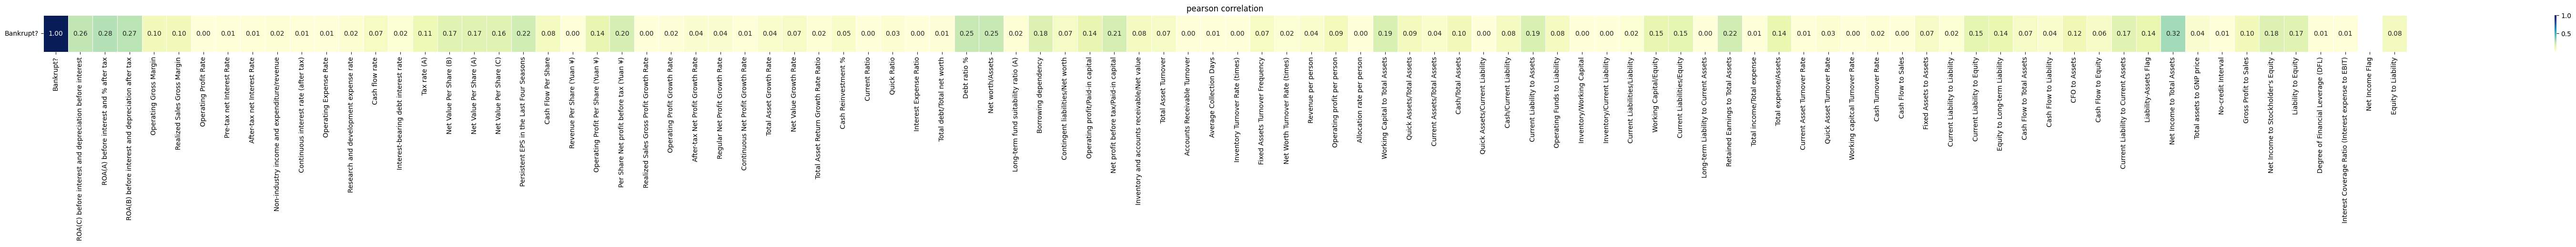

In [47]:
corr = corr_matrix(bankrupt_df, method="pearson", negative=False, lst_filters=["Bankrupt?"], figsize=(80,1))

2. K-Means training

Logistic Regression before changes: accuracy, precision, recall, f1:  0.9015151515151515 0.8839941262848752 0.9218989280245024 0.9025487256371814


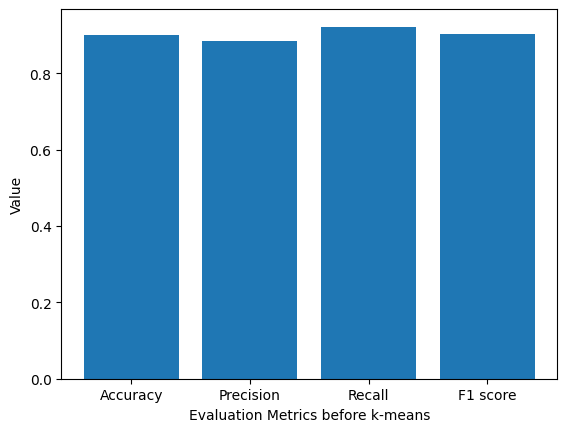

The max accuracy we could get is 0.906060606060606
The max precision we could get is 0.8903703703703704
The max recall we could get is 0.9257274119448698
The max f1 we could get is 0.9069069069069069
We gain a better accuracy of the model of 0.4545454545454519 %
We gain a better precision of the model of 0.6376244085495197 %
We gain a better recall of the model of 0.3828483920367498 %
We gain a better f1 score of the model of 0.4358181269725536 %


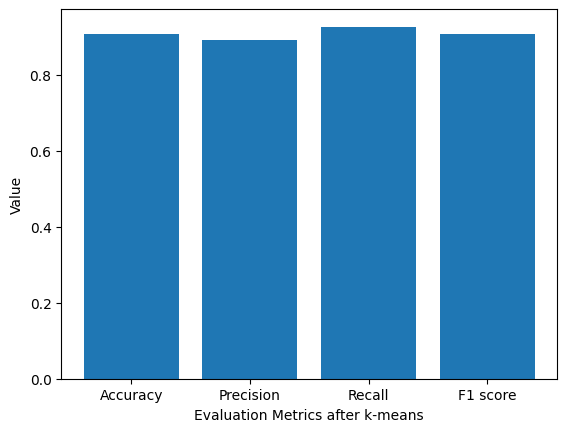

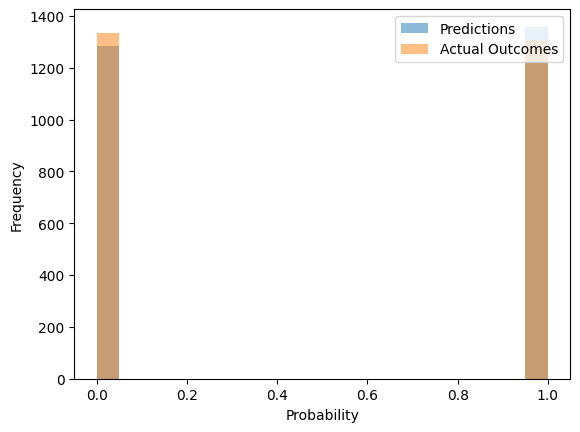

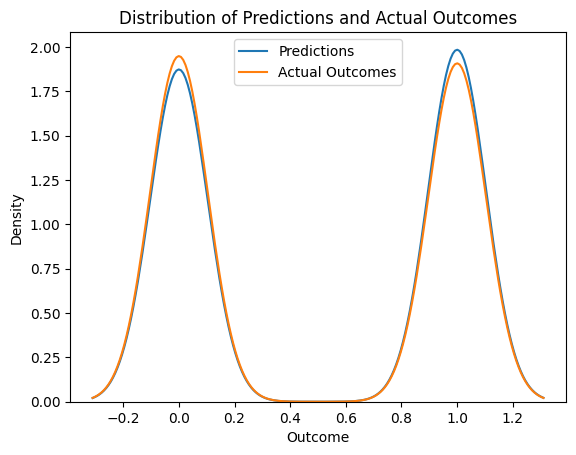

In [48]:
Y_pred_k_means_bankrupt = k_means_identify(copy.deepcopy(X_train_bankrupt), copy.deepcopy(X_test_bankrupt), copy.deepcopy(Y_train_bankrupt), copy.deepcopy(Y_test_bankrupt), "Bankrupt?")

3. SVM training

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-25199 (build 11.0.12+7, mixed mode)
  Starting server from C:\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmptf4zdhw9
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmptf4zdhw9\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmptf4zdhw9\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,35 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_Administrator_xqmxka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.945 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:48:06.924: AutoML: XGBoost is not available; skipping it.
15:48:07.544: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

████
15:48:23.137: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

███████████████████████████████████████████████
15:52:09.862: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]

████████████| (done) 100%
model_id                                mse            rmse          mae    rmsle    mean_residual_deviance
GBM_1_AutoML_1_20230309_154806  0.00968878        0.0984316     0.047424      nan               0.00968878
GLM_1_AutoML_1_20230309_154806  1.62797e+11  403481          3927.04          nan               1.62797e+11
[2 rows x 6 columns]

Parse progress: |██████████████████████████████

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.1min finished
Features: 1/1

Evaluation Metrics:
                  Best Model          SVM Model
Accuracy:         0.249242            0.834091
Precision:        0.039510            0.838534
Recall:           0.022205            0.823124
F1 Score:         0.028431            0.830757
We gain a better accuracy of the model of -58.484848484848484 %
We gain a better precision of the model of -79.90240045569126 %
We gain a better recall of the model of -80.09188361408881 %
We gain a better f1 score of the model of -80.23259690274872 %


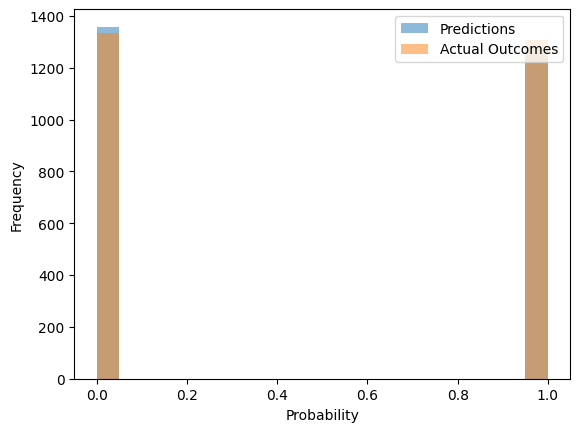

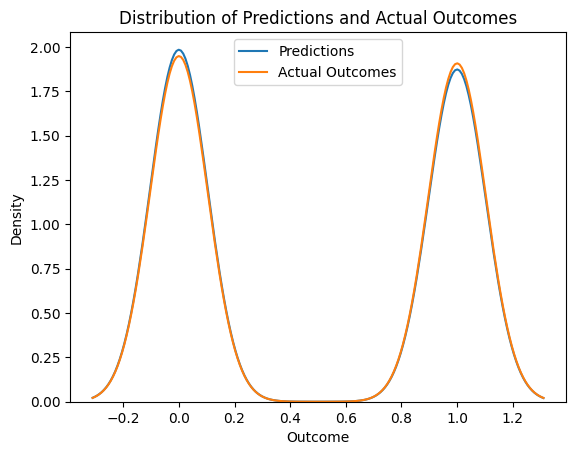

In [49]:
Y_pred_svm_bankrupt = svm_training(copy.deepcopy(X_train_bankrupt), copy.deepcopy(X_test_bankrupt), copy.deepcopy(Y_train_bankrupt), copy.deepcopy(Y_test_bankrupt), copy.deepcopy(bankrupt_df), "Bankrupt?")

Comparison between K-Means and SVM

[1 1 0 ... 0 0 0]


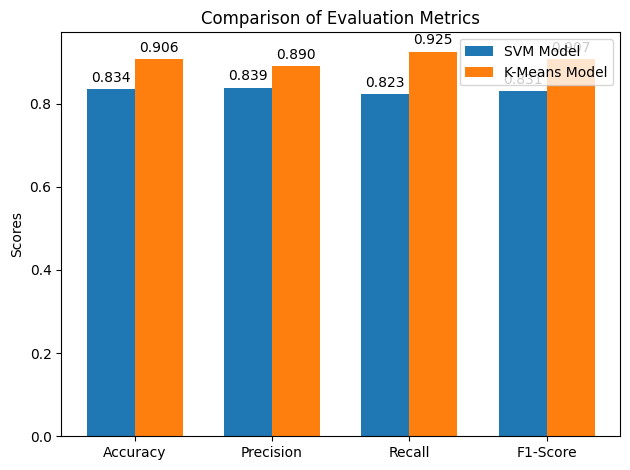

In [50]:
py_different_model(Y_pred_svm_bankrupt, Y_pred_k_means_bankrupt, Y_test_bankrupt)

### Dataset 2 - [Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

1. Data Pre-Processing

In [51]:
# Load the customer churn dataset into dataframe.
churn_df = pd.read_csv('../data/raw/customer_churn.csv')
churn_df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [52]:
# Total Charges column was categorical but must be a numerical value.
# hence we convert it to categorical and fill with NAN values if there are errors.
churn_df["TotalCharges"] = pd.to_numeric(churn_df["TotalCharges"], errors='coerce')

In [53]:
# Find out how many Nan values are in the dataset now
churn_df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [54]:
# drop NaN values since they are small
churn_df.dropna(subset=["TotalCharges"], inplace=True)
churn_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [55]:
# Also we don't need the customer ID columm
churn_df.drop("customerID", axis=1, inplace=True)

In [56]:
# As expected there are no missing values in any of the columns. Dataset seems to be clean
# display general statistics of dataset
churn_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [57]:
# maping of male to 1 and female to zero.
churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})
# maping of yes to 1 and No to 0 for the following column
churn_df['Partner'] = churn_df['Partner'].map({'Yes': 1, 'No': 0})
churn_df['Dependents'] = churn_df['Dependents'].map({'Yes': 1, 'No': 0})
churn_df['PhoneService'] = churn_df['PhoneService'].map({'Yes': 1, 'No': 0})
churn_df['PaperlessBilling'] = churn_df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
churn_df['Churn'] = churn_df['Churn'].map({'Yes': 1, 'No': 0})
churn_df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [58]:
# get dummy for categorical columns now
churn_df = pd.get_dummies(churn_df)
churn_df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


In [59]:
# Extract the features and labels
X_churn = churn_df.drop(['Churn'], axis=1)
Y_churn = churn_df['Churn']

over_sample = SMOTE()
X_ros_churn, Y_ros_churn = over_sample.fit_resample(X_churn, Y_churn)

# we split the data into training and testing sets
X_train_churn, X_test_churn, Y_train_churn, Y_test_churn = train_test_split(X_ros_churn, Y_ros_churn, test_size=0.2, random_state=42)

Present the relationship between all pairs of columns in a dataset

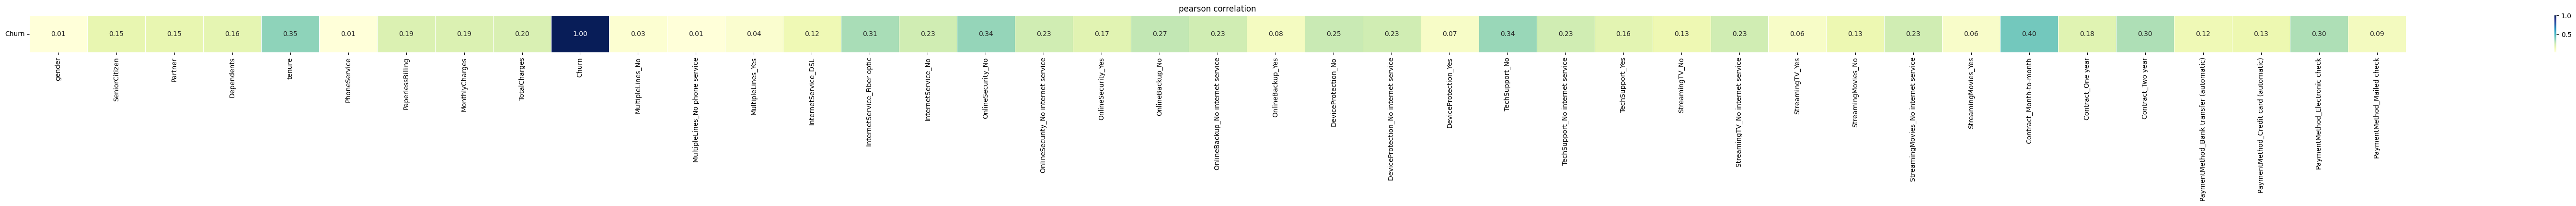

In [60]:
corr = corr_matrix(churn_df, method="pearson", negative=False, lst_filters=[ProcessConfig.churn_label], figsize=(80,1))

2. K-Means training

Logistic Regression before changes: accuracy, precision, recall, f1:  0.8504356243949661 0.8428571428571429 0.8600583090379009 0.8513708513708514


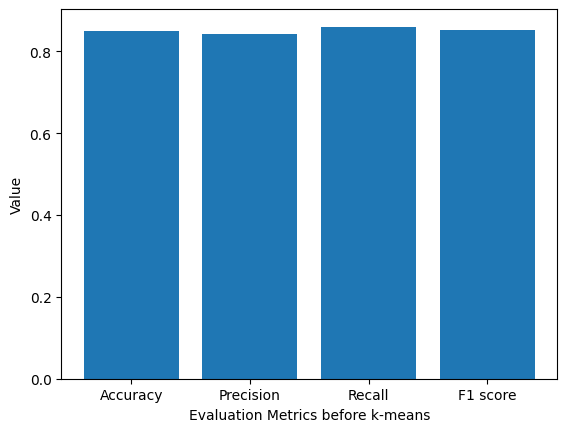

The max accuracy we could get is 0.8518877057115198
The max precision we could get is 0.8479307025986526
The max recall we could get is 0.8678328474246841
The max f1 we could get is 0.8520309477756287
We gain a better accuracy of the model of 0.14520813165537216 %
We gain a better precision of the model of 0.5073559741509692 %
We gain a better recall of the model of 0.7774538386783214 %
We gain a better f1 score of the model of 0.06600964047772662 %


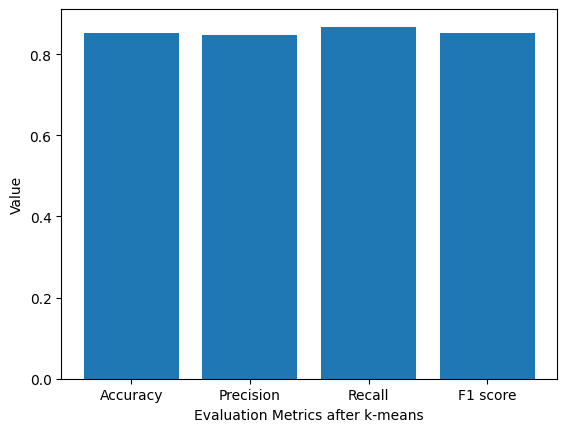

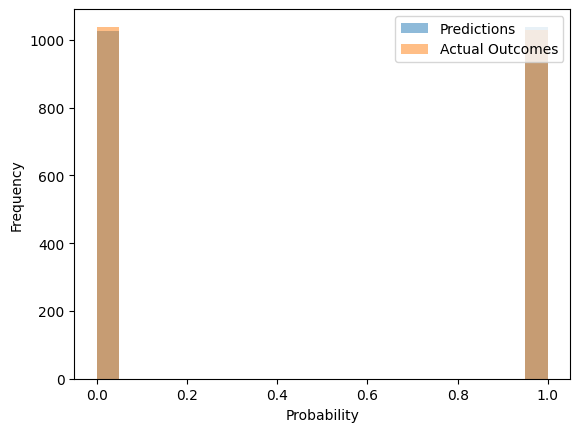

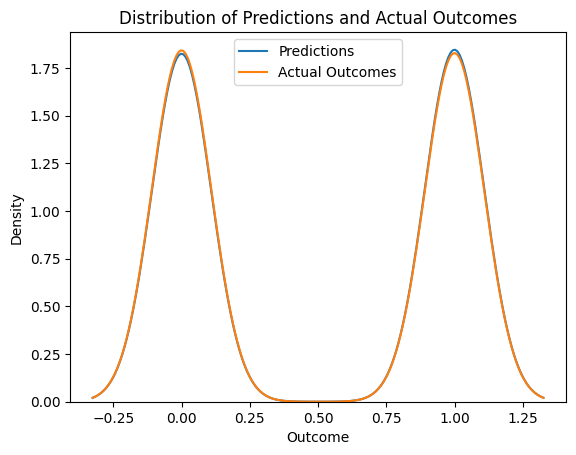

In [61]:
Y_pred_k_means_churn = k_means_identify(copy.deepcopy(X_train_churn), copy.deepcopy(X_test_churn), copy.deepcopy(Y_train_churn), copy.deepcopy(Y_test_churn), 'Churn')

3. SVM training

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,9 mins 01 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_Administrator_xqmxka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
15:56:38.767: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                          mse      rmse       mae       rmsle    mean_residual_deviance
XRT_1_AutoML_2_20230309_155638               0.10095   0.317726  0.117587    0.499616                  0.10095
DRF_1_AutoML_2_20230309_155638               0.102983  0.320909  0.11571     0.496747                  0.102983
GBM_grid_1_AutoML_2_20230309_155638_model_1  0.103259  0.32134   0.149802  nan                         0.103259
GBM_4_AutoML_2_20230309_155638               0.104433  0.32316   0.141027  nan                         0.104433
GBM_3_AutoML_2_20230309_155638               0.10671   0.326665  0.142678  nan                         0.10671
GBM_grid_1_AutoML_2_20230309_155638_model_3  0.108197  0.328933  0.154509  na

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.5s finished
Features: 1/1

Evaluation Metrics:
                  Best Model          SVM Model
Accuracy:         0.418683            0.701839
Precision:        0.098131            0.656321
Recall:           0.020408            0.842566
F1 Score:         0.033789            0.737872
We gain a better accuracy of the model of -28.315585672797678 %
We gain a better precision of the model of -55.819012784141165 %
We gain a better recall of the model of -82.21574344023324 %
We gain a better f1 score of the model of -70.40831207956045 %


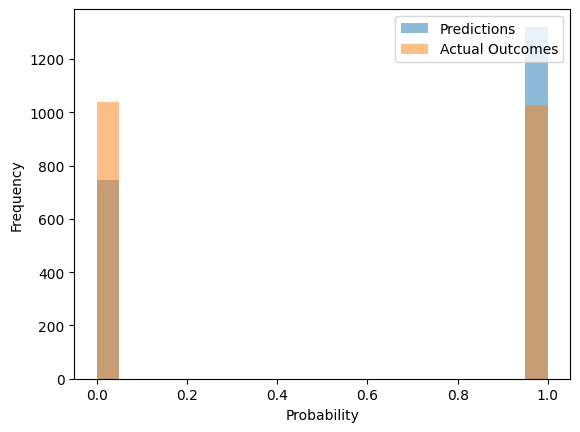

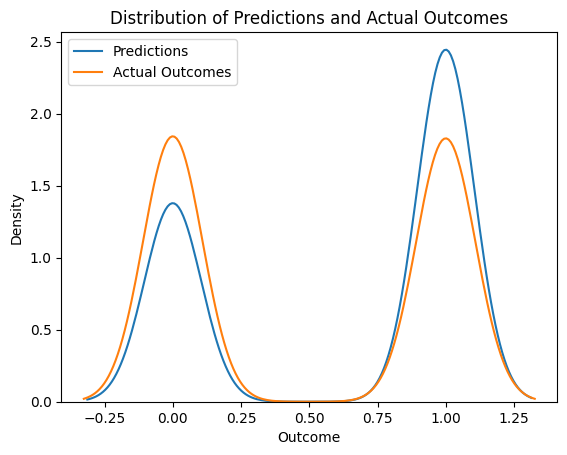

In [62]:
Y_pred_svm_churn = svm_training(copy.deepcopy(X_train_churn), copy.deepcopy(X_test_churn), copy.deepcopy(Y_train_churn), copy.deepcopy(Y_test_churn), copy.deepcopy(churn_df), ProcessConfig.churn_label)

Comparison between K-Means and SVM

[1 0 0 ... 1 1 1]


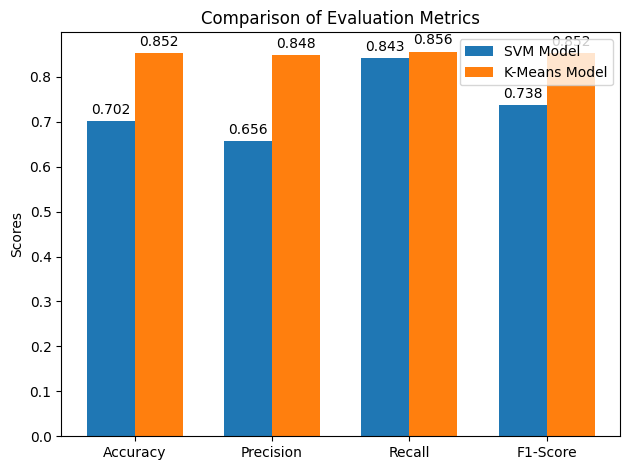

In [63]:
py_different_model(Y_pred_svm_churn, Y_pred_k_means_churn, Y_test_churn)

### Dataset 3- [Diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

1. Data Pre-Processing

In [64]:
# Load the diabetes dataset into dataframe.
diabetes_df = pd.read_csv('../data/raw/health_diabetes.csv')
diabetes_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [65]:
# Find out how many Nan values are in the dataset now
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [66]:
# 2. All the features are required for the ml process

# 3. Convert to numeric Outcome feature
# 0 - no diabetes. 1 - no diabetes.
diabetes_df["Outcome"] = pd.to_numeric(diabetes_df["Outcome"],
                                                              errors='coerce')

In [67]:
diabetes_df = pd.get_dummies(diabetes_df)
diabetes_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [68]:
# After cleaning and processing the database, display general statistics of dataset
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Present the relationship between all pairs of columns in a dataset

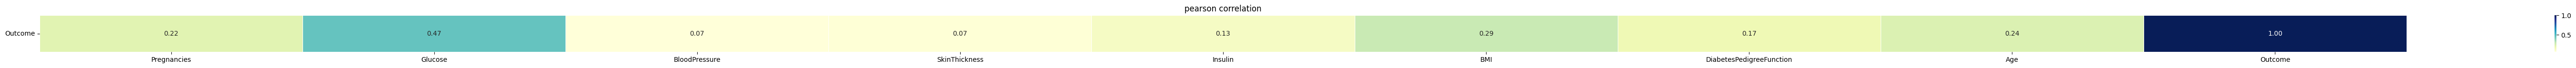

In [69]:
corr = corr_matrix(diabetes_df, method="pearson", negative=False, lst_filters=[ProcessConfig.diabetes_label], figsize=(80,1))

In [70]:
# Extract the features and labels
X_diabetes = diabetes_df.drop(["Outcome"], axis=1)
Y_diabetes = diabetes_df["Outcome"]

over_sample = SMOTE()
X_ros_diabetes, Y_ros_diabetes = over_sample.fit_resample(X_diabetes, Y_diabetes)

# we split the data into training and testing sets
X_train_diabetes, X_test_diabetes, Y_train_diabetes, Y_test_diabetes = train_test_split(X_ros_diabetes, Y_ros_diabetes, test_size=0.2, random_state=42)

2. K-means training

Logistic Regression before changes: accuracy, precision, recall, f1:  0.745 0.7551020408163265 0.7326732673267327 0.743718592964824


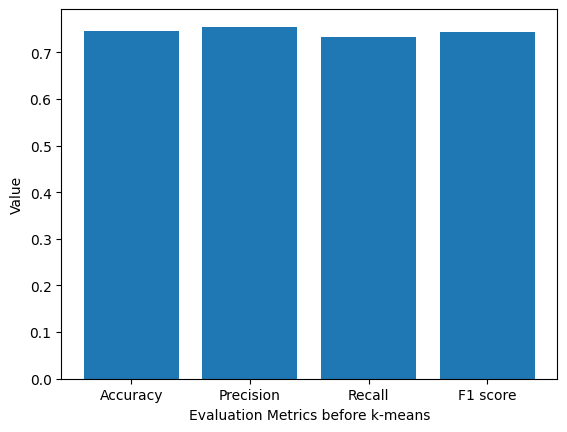

All features are constant in this cluster
All features are constant in this cluster
All features are constant in this cluster
All features are constant in this cluster
All features are constant in this cluster
All features are constant in this cluster
The max accuracy we could get is 0.74
The max precision we could get is 0.7525773195876289
The max recall we could get is 0.7326732673267327
The max f1 we could get is 0.74
We gain a better accuracy of the model of -0.5000000000000004 %
We gain a better precision of the model of -0.2524721228697624 %
We gain a better recall of the model of 0.0 %
We gain a better f1 score of the model of -0.3718592964824019 %


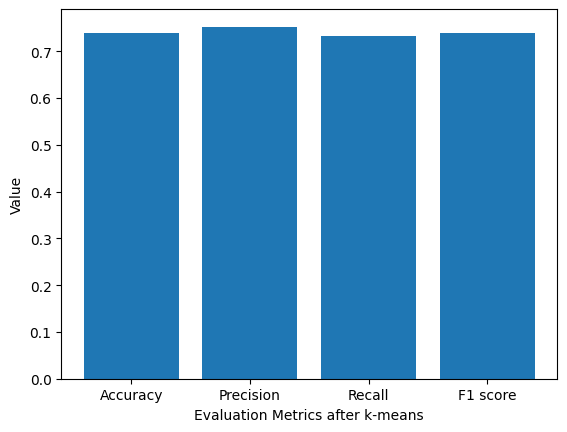

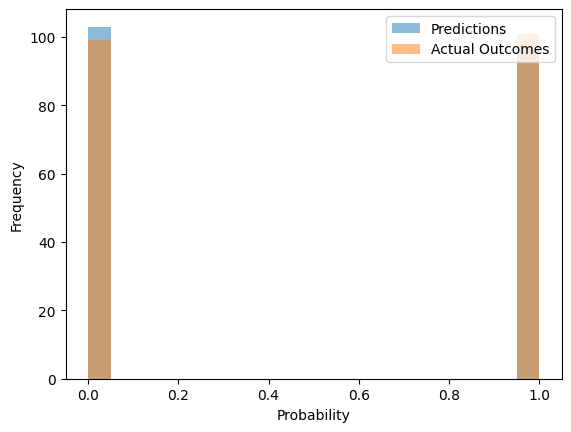

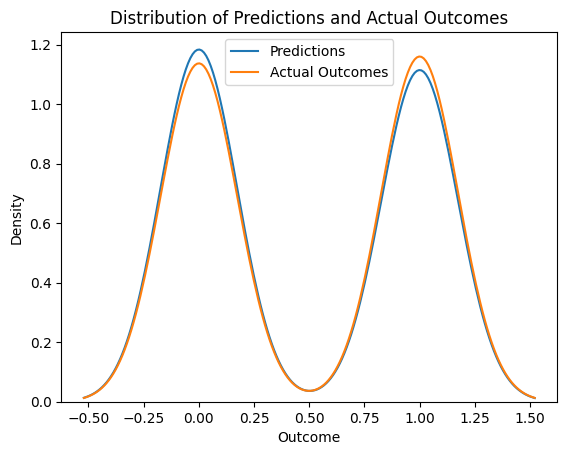

In [71]:
Y_pred_k_means_diabetes = k_means_identify(copy.deepcopy(X_train_diabetes), copy.deepcopy(X_test_diabetes), copy.deepcopy(Y_train_diabetes), copy.deepcopy(Y_test_diabetes), 'Outcome')

3. SVM training

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 mins 06 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_Administrator_xqmxka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.745 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
16:04:31.714: AutoML: XGBoost is not available; skipping it.
16:04:31.719: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
16:04:31.900: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
16:04:32.521: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
16:04:34.148: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   12.1s remaining:   36.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   12.7s finished
Features: 1/1

Evaluation Metrics:
                  Best Model          SVM Model
Accuracy:         0.815000            0.680000
Precision:        0.775862            0.707865
Recall:           0.891089            0.623762
F1 Score:         0.829493            0.663158
We gain a better accuracy of the model of 13.49999999999999 %
We gain a better precision of the model of 6.799690042619144 %
We gain a better recall of the model of 26.732673267326735 %
We gain a better f1 score of the model of 16.633519282076158 %


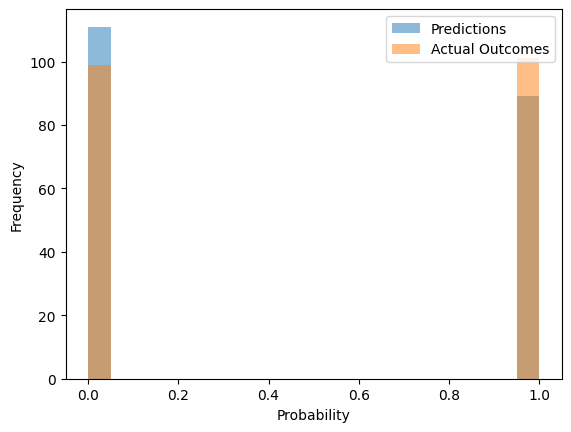

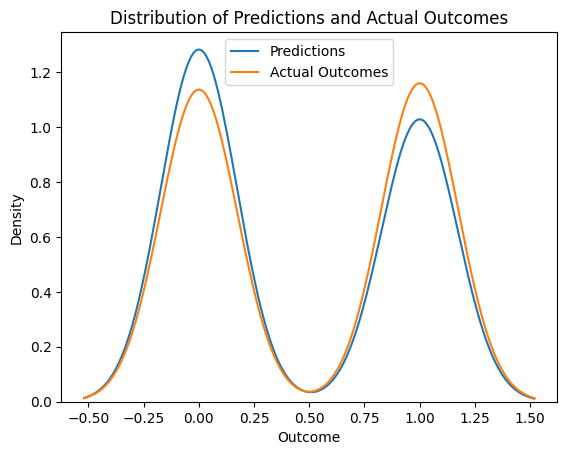

In [72]:
Y_pred_svm_diabetes = svm_training(copy.deepcopy(X_train_diabetes), copy.deepcopy(X_test_diabetes), copy.deepcopy(Y_train_diabetes), copy.deepcopy(Y_test_diabetes), copy.deepcopy(diabetes_df), ProcessConfig.diabetes_label)

Comparison between K-Means and SVM

[0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0
 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1
 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1
 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1]


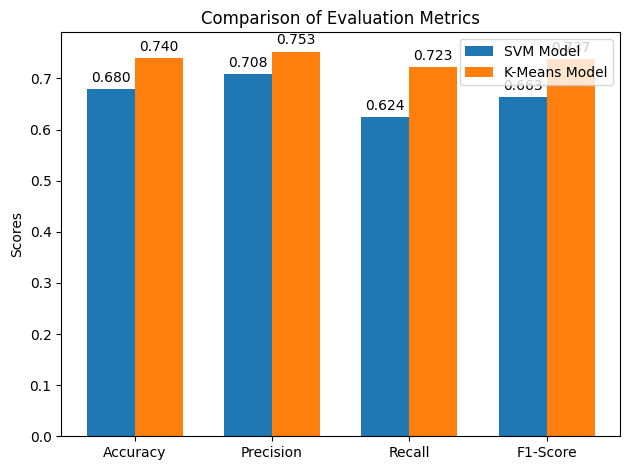

In [73]:
py_different_model(Y_pred_svm_diabetes, Y_pred_k_means_diabetes, Y_test_diabetes)

### DataSet 4 - [Credit Card](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

1. Data Pre-Processing

In [74]:
# Load the credit card dataset into dataframe.
creditcard_df = pd.read_csv('../data/raw/creditcard.csv')
creditcard_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [75]:
# Find out how many Nan values are in the dataset now
creditcard_df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [76]:
# 2. All the features are required for the ml process

# 3. Convert to numeric Class feature
# 0 - non-fraudulent. 1 - fraudulent.
creditcard_df["Class"] = pd.to_numeric(creditcard_df["Class"], errors='coerce')
creditcard_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [77]:
creditcard_df = pd.get_dummies(creditcard_df)
# After cleaning and processing the database, display general statistics of dataset
creditcard_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Present the relationship between all pairs of columns in a dataset

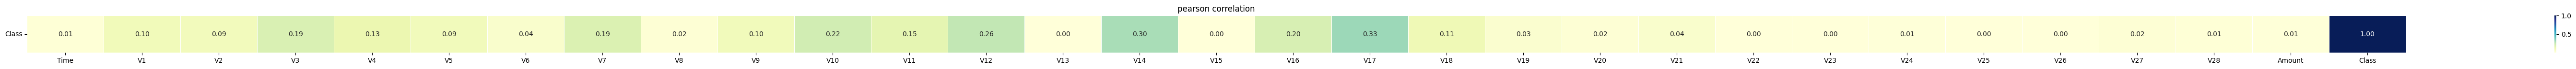

In [78]:
corr = corr_matrix(creditcard_df, method="pearson", negative=False, lst_filters=[ProcessConfig.creditcard_label], figsize=(80,1))

In [79]:
X_creditcard = creditcard_df.drop(["Class"], axis=1)
Y_creditcard = creditcard_df["Class"]

over_sample = SMOTE()
X_ros_creditcard, Y_ros_creditcard = over_sample.fit_resample(X_creditcard, Y_creditcard)

# we split the data into training and testing sets
X_train_creditcard, X_test_creditcard, Y_train_creditcard, Y_test_creditcard = train_test_split(X_ros_creditcard, Y_ros_creditcard, test_size=0.2, random_state=42)

2. K-means training

Logistic Regression before changes: accuracy, precision, recall, f1:  0.9804881909150063 0.9907156811786425 0.9701453243470936 0.9803226063900541


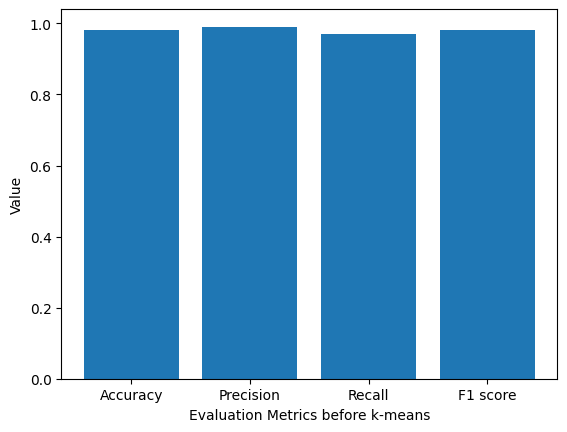

The max accuracy we could get is 0.9805145701070995
The max precision we could get is 0.9908041444089914
The max recall we could get is 0.9701102218477956
The max f1 we could get is 0.9803479895709548
We gain a better accuracy of the model of 0.0026379192093251014 %
We gain a better precision of the model of 0.008846323034894521 %
We gain a better recall of the model of -0.00351024992979454 %
We gain a better f1 score of the model of 0.0025383180900728775 %


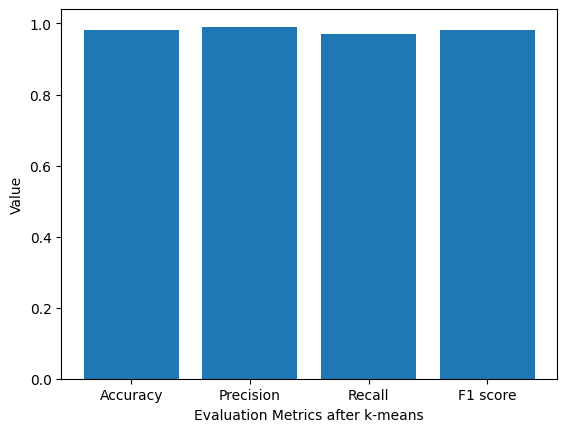

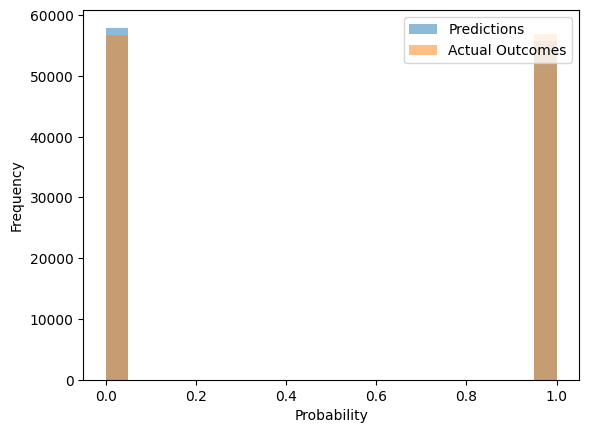

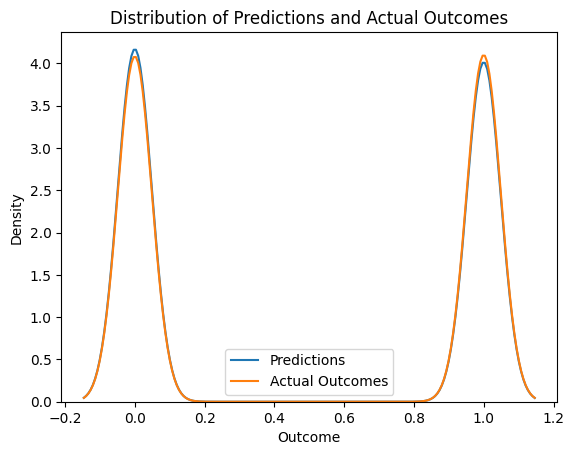

In [80]:
Y_pred_k_means_creditcard = k_means_identify(copy.deepcopy(X_train_creditcard), copy.deepcopy(X_test_creditcard), copy.deepcopy(Y_train_creditcard), copy.deepcopy(Y_test_creditcard), "Class")

3. SVM training

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,28 mins 53 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_Administrator_xqmxka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.775 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
16:17:11.828: AutoML: XGBoost is not available; skipping it.
16:17:11.838: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
16:17:15.46: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                               mse      rmse        mae      rmsle    mean_residual_deviance
GBM_1_AutoML_4_20230309_161711  0.00080208  0.028321  0.0101885  0.0246048                0.00080208
GLM_1_AutoML_4_20230309_161711  0.0759556   0.2756    0.220241   0.182141         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished
Features: 1/1

Evaluation Metrics:
                  Best Model          SVM Model
Accuracy:         0.999798            0.943874
Precision:        0.999596            0.975579
Recall:           1.000000            0.910769
F1 Score:         0.999798            0.942061
We gain a better accuracy of the model of 5.592388723774688 %
We gain a better precision of the model of 2.4017908825951784 %
We gain a better recall of the model of 8.923055321538897 %
We gain a better f1 score of the model of 5.773751167973462 %


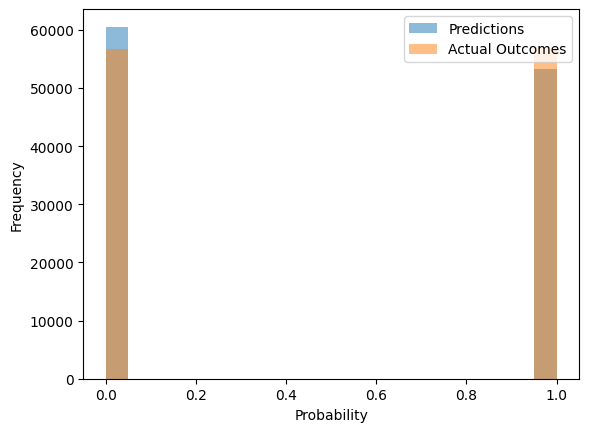

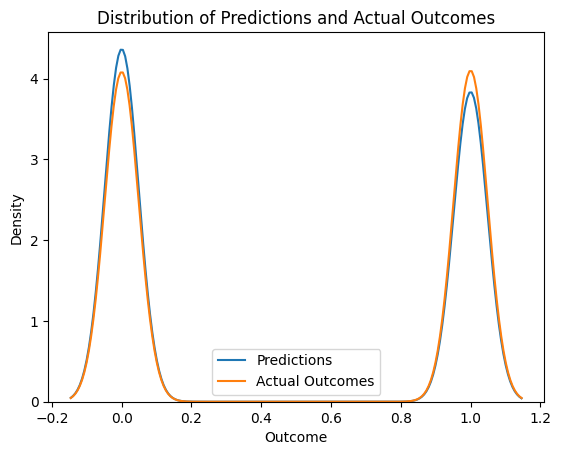

In [81]:
Y_pred_svm_creditcard = svm_training(copy.deepcopy(X_train_creditcard), copy.deepcopy(X_test_creditcard), copy.deepcopy(Y_train_creditcard), copy.deepcopy(Y_test_creditcard), copy.deepcopy(creditcard_df), ProcessConfig.creditcard_label)

Comparison between K-Means and SVM

[1 1 0 ... 1 0 0]


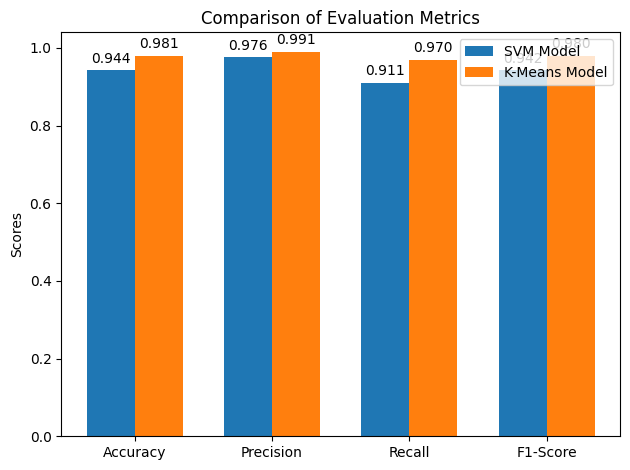

In [82]:
py_different_model(Y_pred_svm_creditcard, Y_pred_k_means_creditcard, Y_test_creditcard)  